<a href="https://colab.research.google.com/github/carlachka/7605_TP1/blob/master/tp1_GMC_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? Disaster Tweets - EDA

In [0]:
# import the bilbiotecas
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2

from scipy import stats
from collections import Counter

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk.util import ngrams

## all reviews
# building of the bi-grams
#Counter(list(ngrams(reviews_without_stop_words, 2))).most_common(20)

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#https://drive.google.com/open?id=1VkZ0rnoUMvwbXR9t7z9OccNZAyty40v-

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1VkZ0rnoUMvwbXR9t7z9OccNZAyty40v-'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train.csv')


In [0]:
# Load the Data and take a quick look for train.csv
df = pd.read_csv('train.csv', encoding='latin-1')
df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


### Descripción de las columnas

##### falta breve descripción

**id** - identificador unico para cada  tweet  
**text** - el texto del tweet  
**location** - ubicación desde donde fue enviado (podría no estar)  
**keyword** - un keyword para el tweet  (podría faltar)  
**target** - en train.csv, indica si se trata de un desastre real  (1) o no (0)

In [0]:
display(df.sample(3))

,id,keyword,location,text,target
2074,2976,dead,dundalk ireland,@emmerdale is Ross really dead?? #AskCharley,0
3553,5078,famine,"Edappally,Kochi",Building Muscle With Feast And Famine Feeding ...,0
1105,1597,bombed,NaN,Photo bombed ???? http://t.co/arTUMHmBhh,0


Teniendo un idea general sobre lo que trata el dataset, iremos más en profundidad con cada una de las 4 variables.

### Valores faltantes

In [0]:
# % de nulos por columna
df.isnull().sum() / df.shape[0] * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Un tercio de los tweets no tiene definida la locación. Más adelante intentaremos  lidiar con eso.

###Duplicados

In [0]:
df.shape

(7613, 5)

In [0]:
train_df=df.drop_duplicates(['keyword','text','location'], inplace=False)

In [0]:
train_df.shape

(7552, 5)

In [0]:
7613 - 7552

61

Al momento de quitar duplicados en la base de datos, comparamos cuantos registros se perdian considerando las variables keyword, text y location. En este caso se estarian eliminando 61 registros. Tambien analizamos cuantos registros se perderian si consideramos la variable target.

In [0]:
train2_df=df.drop_duplicates(['keyword','text','location','target'], inplace=False)

In [0]:
train2_df.shape

(7561, 5)

In [0]:
7613 - 7561

52

Al incluir la variable target, vemos que eliminariamos 52 registros duplicados. Esto quiere decir que hay tweets que son completamente iguales - no solo incluyendo su texto, tambien location y su keyword - , pero que hay veces en las que estan marcados como desastre (target = 1) y otras veces en las que estan marcados como no desastre (target = 0).

Consideramos que esta es una inconsistencia en la base de datos, que afectaria el objetivo de predecir si un cierto tweet es real o no en el futuro. Consecuentemente decidimos quedarnos con los registros unicos considerando las variables text keyword y location.

De esta forma, cuando vuelve a aparcer un registro que tiene el mismo text keyword y location, se elimina. Eliminamos 52 registros repetidos.

### Variables

#### keyword

Se trata de  221 palabras clave. Aquí las 20 más repetidas.


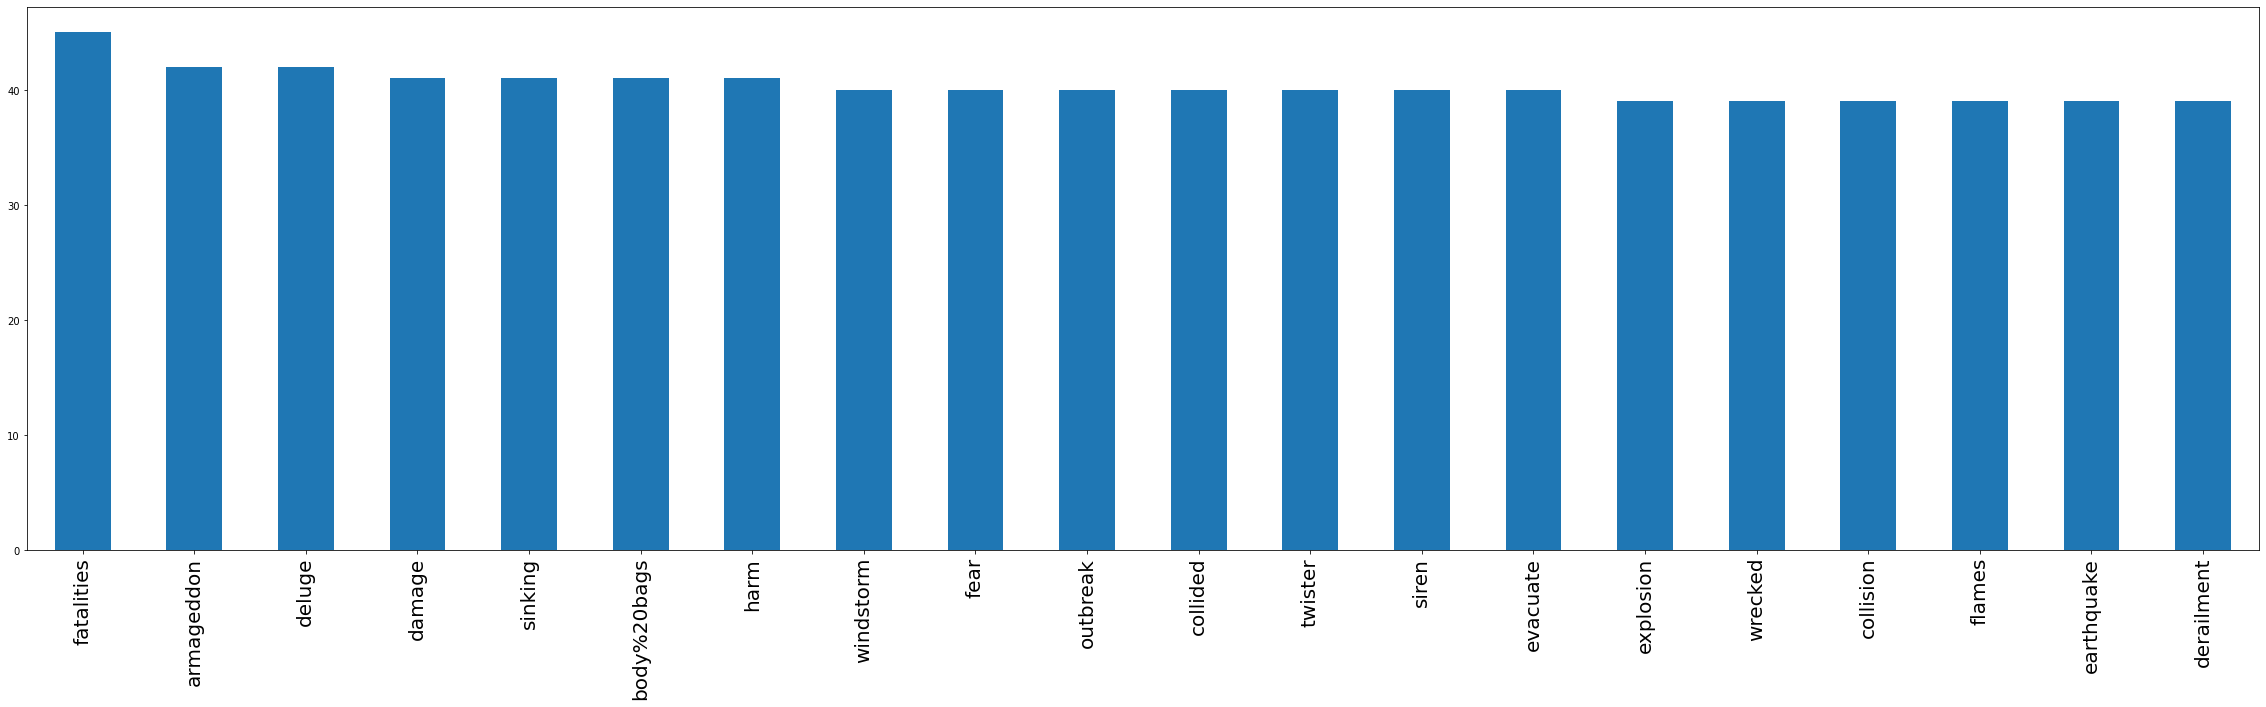

In [0]:
# histograma para identificar alguna/as palabra clave particular
## plt configs
plt.figure(figsize=[40,10])
plt.xticks(fontsize=20, rotation=70)

df['keyword'].value_counts().head(20).plot(kind='bar')
print('Se trata de ', df['keyword'].nunique(), 'palabras clave. Aquí las 20 más repetidas.')

Por el momento, no exige más análisis como variable en sí en el data frame train, ya que es una palabra clave asignada. Más adelante estudiaremos si exige alguna relación con otra variable.

Lo que si podemos ver es si estas keywords tambien se encuentran en el data frame test.

In [0]:
id='1JbnfMMVuipDT_pQ1FYD2shLRkFAf14ov'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test.csv')

In [0]:
# https://drive.google.com/open?id=1JbnfMMVuipDT_pQ1FYD2shLRkFAf14ov

In [0]:
# # Rapida vista de test.csv
test_df = pd.read_csv('test.csv', encoding='latin-1')
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


Se trata de  221 palabras clave. Aquí las 20 más repetidas.


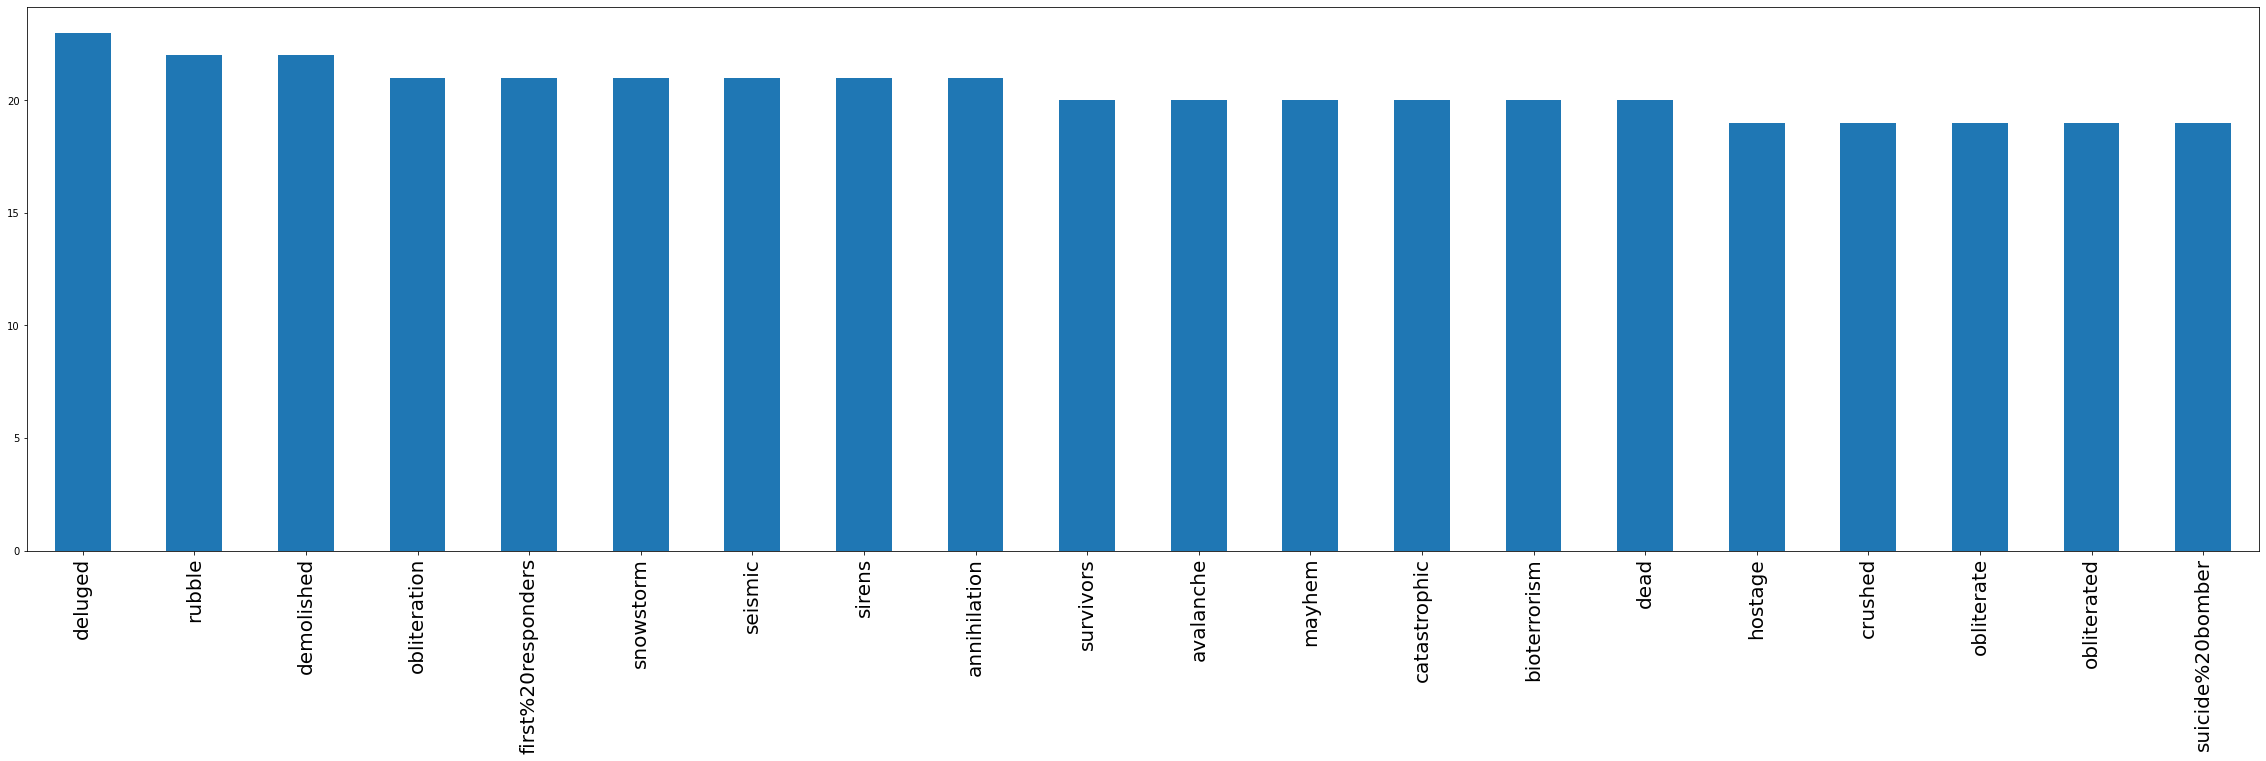

In [0]:
plt.figure(figsize=[40,10])
plt.xticks(fontsize=20, rotation=70)

test_df['keyword'].value_counts().head(20).plot(kind='bar')
print('Se trata de ', test_df['keyword'].nunique(), 'palabras clave. Aquí las 20 más repetidas.')

Pareceria que las 221 keywords que se encuentran en el data frame train, tambien se encuentran en el test data frame. Consecuentemente, la variable keyword podria ser util al momento de predecir si los tweets son reales o no.

####target

In [0]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

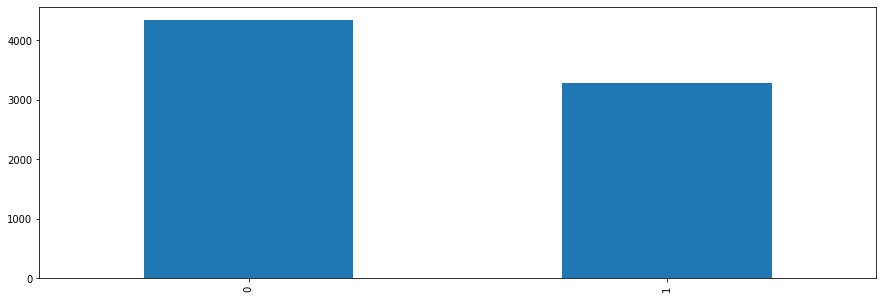

In [0]:

df['target'].value_counts().sort_index().plot(kind='bar', figsize=(15,5)); # ver layout



Hay más no desastres que desastres.

Analizamos la relacion de la variable keyword con target en el siguiente gráfico.

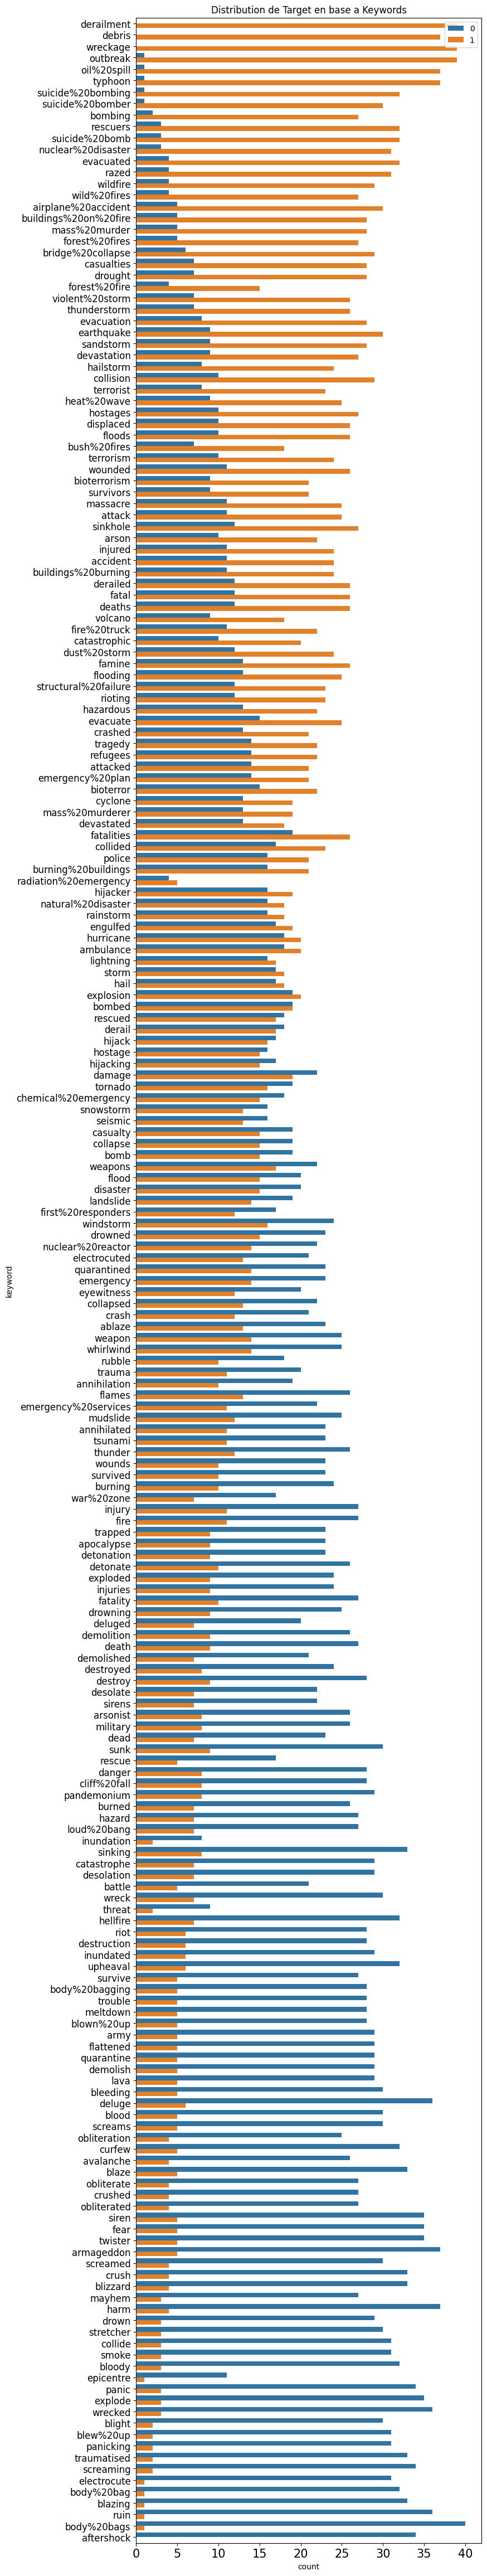

In [0]:
df['target_mean'] = df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 60), dpi=100)

sns.countplot(y=df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Distribution de Target en base a Keywords')
plt.show()
df.drop(columns=['target_mean'], inplace=True)

Hay palabras como debris, wreckage, derailment son siempre desastres (target = 1). Mientras que aftershock no lo es (target = 0).

#### location

Se registraron tweets desde  3341 lugares.


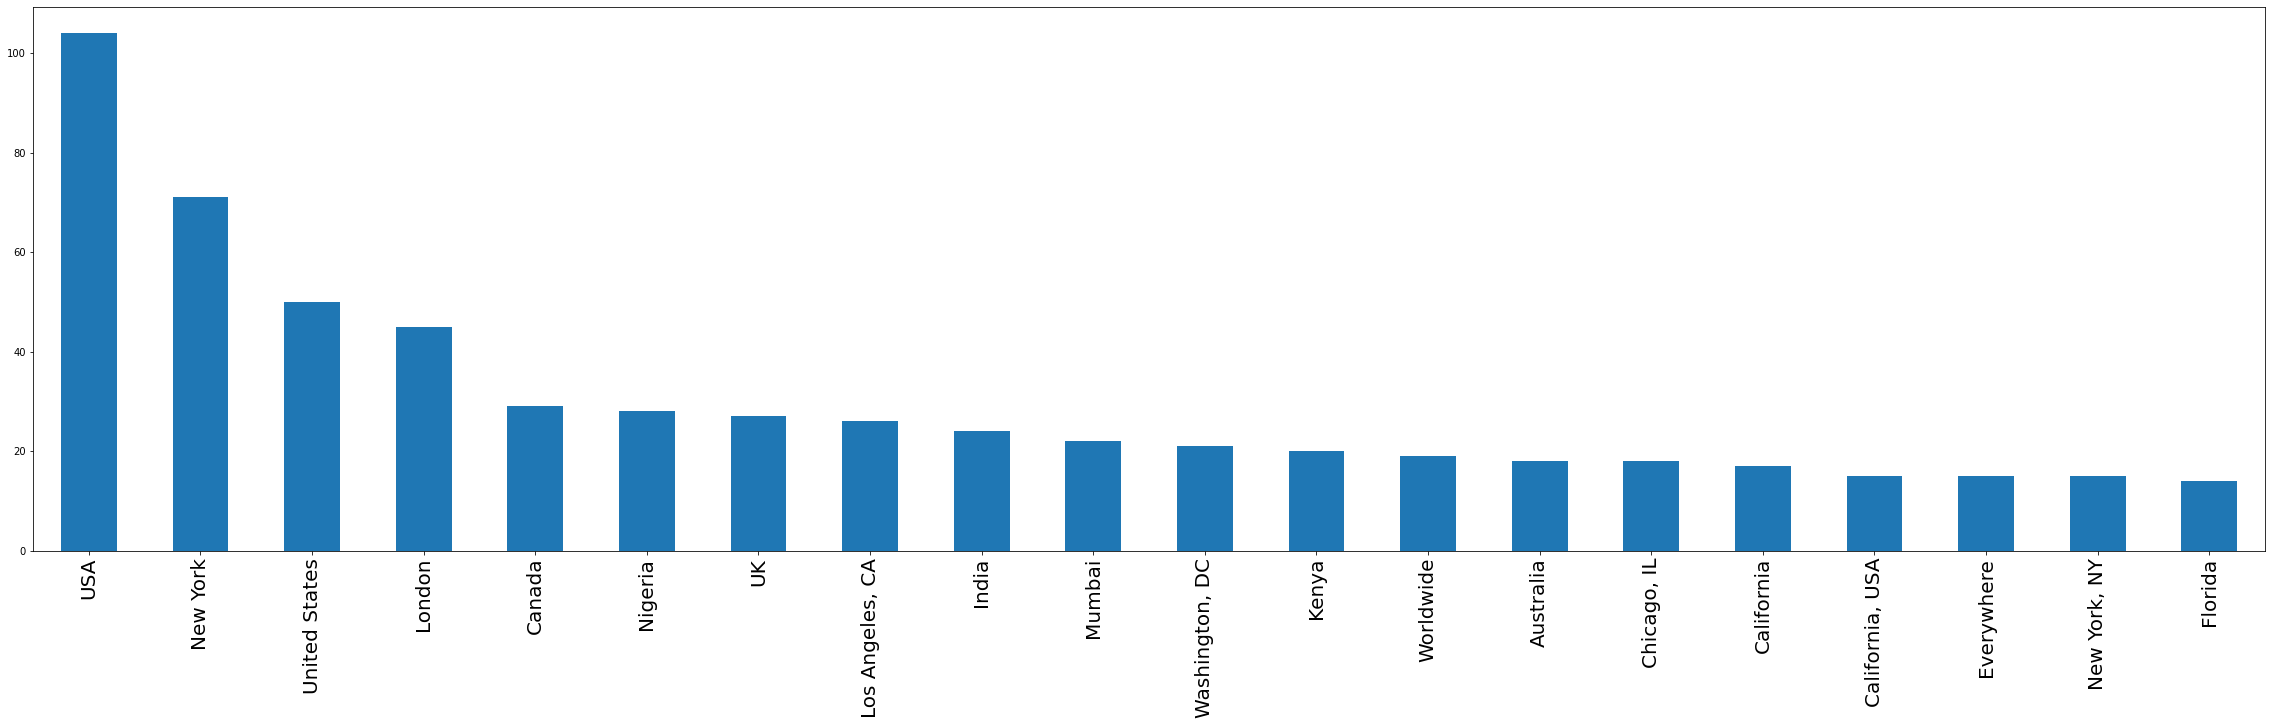

In [0]:
# histograma para identificar alguna/as locación particular
## plt configs
plt.figure(figsize=[40,10])
plt.xticks(fontsize=20, rotation=70)

df['location'].value_counts().head(20).plot(kind='bar')
print('Se registraron tweets desde ', df['location'].nunique(), 'lugares.')

No es correcto hablar de 3341 lugares distintos ya que dentro del listado de locaciones hay paises y estados, y mezclas de ambos. Incluso podemos ver a Estados Unidos escrito de dos maneras distintas y considerado como dos lugares distintos.
Ya que los estados figuran con su nombre y su código podríamos utilizar eso para facilmemnte asignarle a USA como pais.
Próximamente haremos otro tratamiento de las localidades.

Asimismo, podemos ver que la variable locations no esta automaticamente generada, sino que es un input que ingresa el usuario. Por este motivo, es que hay tantos "lugares distintos".

####text

In [0]:
text = df['text']

In [0]:
len(text)

7613

In [0]:
len(text.unique())

7503

Habria 110 tweets repetidos. Es decir, considerando solamente el texto del tweet, vemos que hay 110 repetido. 
Combinaremos el texto con otras variables para terminar de decidir que duplicados eliminar de la base de datos.

Analizamos estas combinaciones anteriormente.

##### Ejemplos de tipos de observaciones

In [0]:

# ejemplos de observaciones positivas (target=1)
print(df.text.loc[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


In [0]:
print(df.target.loc[0])

1


In [0]:
df[df.target==1].sample(5)

,id,keyword,location,text,target
3891,5532,flattened,Leeds,Flattened thee striker,1
1335,1929,burning%20buildings,NaN,@fewmoretweets all lives matter. Just not a fa...,1
7027,10072,typhoon,NaN,Typhoon Soudelor: When will it hit Taiwan ÂÃ...,1
6442,9217,suicide%20bombing,NaN,&lt; Suicide Bombing Of European Union Car Kil...,1
2878,4138,drought,Philadelphia,California meets drought-fueled fire season wi...,1


In [0]:
# ejemplos de observaciones negativas (target=0)
df[df.target==0].sample(5)

,id,keyword,location,text,target
1305,1886,burning,NaN,@JohnsonTionne except idk them?? it's really b...,0
388,561,arson,"Kingston, Pennsylvania",The Sound of Arson,0
1034,1500,body%20bags,"WAISTDEEP, TX",@Deeeznvtzzz bring the body bags tho,0
6215,8866,smoke,WORLDWI$E,I smoke toooooo much lmao I was scared to text...,0
1048,1515,body%20bags,In the Shadows...,@Limpar33 sweeping legs? Or putting people in ...,0


In [0]:
print(df.text.loc[7479])

@_PokemonCards_ @IceQueenFroslas why did they have to wreck it with ON SALE HERE ;-;


In [0]:
print(df.target.loc[7479])

0


##### Análisis morfológico

In [0]:
# import de stopwords para depurar los tweets
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# filtro las stop words
every_tweet_text = ''.join(df['text'])
every_tweet_text_words = nltk.word_tokenize(every_tweet_text)

stop_words = list(set(nltk.corpus.stopwords.words("english")))

tweets_without_stop_words = []
tweets_stopwords = []

for word in every_tweet_text_words:
    if word.lower() in stop_words:
        tweets_stopwords.append(word)
    else:
        tweets_without_stop_words.append(word)

# las palabras  más repetidas
tweet_word_freq = Counter(tweets_without_stop_words)

print('The ten most common words are:')
tweet_word_freq.most_common(20)

The ten most common words are:


[(':', 6706),
 ('http', 4258),
 ('#', 3403),
 ('?', 3126),
 ('@', 2759),
 ('.', 2410),
 ('!', 1173),
 ('...', 1063),
 ('-', 779),
 ("'s", 773),
 ("'", 624),
 (';', 587),
 ('&', 457),
 ("n't", 439),
 ('https', 406),
 (')', 373),
 ('(', 349),
 ('amp', 344),
 ('like', 316),
 ("'m", 241)]

In [0]:
# Append de las palabras más comunes y símbolos al listado de stop words
print('# of stopwords:',len(stop_words))

most_common_words = [word for word, count  in tweet_word_freq.most_common(20)]
symobls = [i for i in '! " # $ % & ( ) * + , - . / : ; < = > ? @ [ \ \ ] ^ _ ` { | } ~ \ t\ '.split()]
extra_stop_words = most_common_words + symobls

stop_words = stop_words + extra_stop_words

print('# of stopwords:',len(stop_words))

# of stopwords: 179
# of stopwords: 233


In [0]:
# filtro las stop words nuevamente y las URLs
every_tweet_text = ''.join(df['text'])
every_tweet_text_words = nltk.word_tokenize(every_tweet_text)

tweets_without_stop_words = []
tweets_with_stopwords = []

for word in every_tweet_text_words:
    if (word.lower() in stop_words) | (word.isnumeric()) | ('//t.co' in word.lower()):
        tweets_with_stopwords.append(word)
    else:
        tweets_without_stop_words.append(word)
        
tweets_without_stop_words_freq = Counter(tweets_without_stop_words)

        
print('Las palabras más comunes son:')
tweets_without_stop_words_freq.most_common(20)

Las palabras más comunes son:


[('via', 211),
 ('get', 184),
 ('fire', 162),
 ('people', 162),
 ('one', 153),
 ('would', 128),
 ("'re", 126),
 ('got', 111),
 ('new', 103),
 ('know', 103),
 ('California', 102),
 ('video', 96),
 ('back', 94),
 ('buildings', 94),
 ('disaster', 92),
 ('going', 92),
 ('News', 92),
 ('burning', 91),
 ('killed', 90),
 ('still', 89)]

In [0]:
## tragic tweets
tragic_tweets = df[df['target'] == 1]
tragic_tweets_text = ''.join(tragic_tweets['text'])
tragic_tweets_text_words = nltk.word_tokenize(tragic_tweets_text)


tragic_tweets_without_stop_words = []
tragic_tweets_with_stopwords = []

for word in tragic_tweets_text_words:
    if (word.lower() in stop_words) | (word.isnumeric()) | ('//t.co' in word.lower()):
      tragic_tweets_with_stopwords.append(word)
    else:
        tragic_tweets_without_stop_words.append(word)
        
tragic_tweets_word_freq = Counter(tragic_tweets_without_stop_words)

print('Las más comunes para los tweets trágicos:')
tragic_tweets_word_freq.most_common(20)

Las más comunes para los tweets trágicos:


[('fire', 120),
 ('via', 118),
 ('California', 95),
 ('people', 90),
 ('killed', 87),
 ('News', 74),
 ('Hiroshima', 74),
 ('suicide', 72),
 ('disaster', 68),
 ('fires', 67),
 ('crash', 66),
 ('buildings', 65),
 ('MH370', 64),
 ('Northern', 60),
 ('bomb', 59),
 ('police', 58),
 ('train', 58),
 ('bombing', 58),
 ('Legionnaires', 58),
 ('one', 55)]

In [0]:
## not tragic tweets
not_tragic_tweets = df[df['target'] == 0]
not_tragic_tweets_text = ''.join(not_tragic_tweets['text'])
not_tragic_tweets_text_words = nltk.word_tokenize(not_tragic_tweets_text)


not_tragic_tweets_without_stop_words = []
not_tragic_tweets_with_stopwords = []

for word in not_tragic_tweets_text_words:
    if (word.lower() in stop_words) | (word.isnumeric()) | ('//t.co' in word.lower()):
        not_tragic_tweets_with_stopwords.append(word)
    else:
        not_tragic_tweets_without_stop_words.append(word)
        
not_tragic_tweets_word_freq = Counter(not_tragic_tweets_without_stop_words)

print('Las más comunes para los tweets no-trágicos:')
not_tragic_tweets_word_freq.most_common(20)

Las más comunes para los tweets no-trágicos:


[('get', 143),
 ('one', 98),
 ('would', 93),
 ('via', 93),
 ("'re", 86),
 ('new', 84),
 ('got', 82),
 ('know', 76),
 ('people', 73),
 ('Full', 69),
 ('see', 68),
 ('going', 68),
 ('back', 68),
 ('gt', 67),
 ('body', 67),
 ('video', 64),
 ('time', 63),
 ('still', 62),
 ('YouTube', 62),
 ('think', 61)]

Text(-20, 40, 'Estas son las palabras más freceuntes en común')

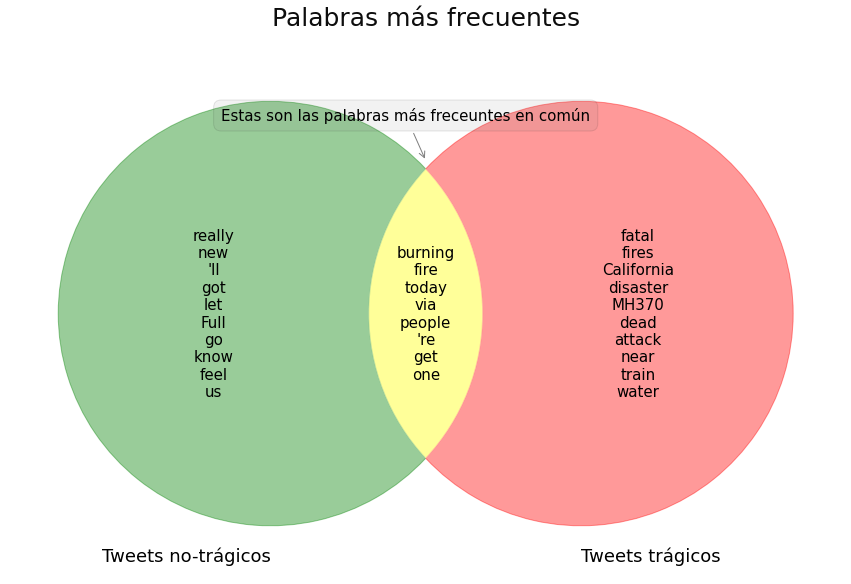

In [0]:
B = set([word for word, count in not_tragic_tweets_word_freq.most_common(50)])
A = set([word for word, count in tragic_tweets_word_freq.most_common(50)])

plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 15})

v = venn2([B,A], ('Tweets no-trágicos', 'Tweets trágicos'))

v.get_label_by_id('10').set_text('\n'.join(list(B-A)[:10]))
v.get_label_by_id('11').set_text('\n'.join(list(A&B)[:10]))
v.get_label_by_id('01').set_text('\n'.join(list(A-B)[:10]))

#plt.rcParams.update({'font.size': 15})
plt.title('Palabras más frecuentes', color=(0.05,0.05,0.05), pad=25, fontsize=25)

v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('01').set_alpha(0.4)

v.get_patch_by_id('10').set_color('green')
v.get_patch_by_id('10').set_alpha(0.4)


v.get_patch_by_id('11').set_color('yellow')
v.get_patch_by_id('11').set_edgecolor('white')
v.get_patch_by_id('11').set_alpha(0.4)


plt.annotate('Estas son las palabras más freceuntes en común', xy=v.get_label_by_id('11').get_position() +
             np.array([0, 0.3]), xytext=(-20,40), ha='center',
             textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',              
                            connectionstyle='arc',color='gray',))
                            

In [0]:
# armado de listado de palabrás que estan presentes unicamente en los tweets trágicos

not_tragic_words = [nt_word for nt_word, nt_count in not_tragic_tweets_word_freq.items()]
tragic_words = [t_word for t_word, t_count in tragic_tweets_word_freq.items()]

not_unique_tragic_words = [word for word in tragic_words if word in not_tragic_words]
not_unique_tragic_words

for word in not_unique_tragic_words:
    tragic_tweets_word_freq.pop(word)
unique_tragic_tweets_word_freq = tragic_tweets_word_freq


print('Palbaras que están presentes en tweets trágicos, únicamente:')
unique_tragic_tweets_word_freq.most_common(10)

Palbaras que están presentes en tweets trágicos, únicamente:


[('MH370', 64),
 ('Northern', 60),
 ('Legionnaires', 58),
 ('bomber', 55),
 ('wildfire', 40),
 ('debris', 37),
 ('migrants', 36),
 ('outbreak', 35),
 ('PKK', 31),
 ('detonated', 31)]

In [0]:
# comparison on words between tragic and not_tragic tweeta, and update of the counter with the unique
# words for tragic tweet

not_tragic_words = [nt_word for nt_word, nt_count in not_tragic_tweets_word_freq.items()]
tragic_words = [t_word for t_word, t_count in tragic_tweets_word_freq.items()]

not_unique_not_tragic_words = [word for word in not_tragic_words if word in tragic_words]


for word in not_unique_not_tragic_words:
    not_tragic_tweets_word_freq.pop(word)
unique_not_tragic_tweets_word_freq = not_tragic_tweets_word_freq


print('Palbaras que están presentes en tweets trágicos, únicamente:')
unique_not_tragic_tweets_word_freq.most_common(10)

Palbaras que están presentes en tweets trágicos, únicamente:


[('get', 143),
 ('one', 98),
 ('would', 93),
 ('via', 93),
 ("'re", 86),
 ('new', 84),
 ('got', 82),
 ('know', 76),
 ('people', 73),
 ('Full', 69)]

In [0]:
from nltk.util import ngrams

## tragic reviews
# building of the bi-grams
Counter(list(ngrams(tragic_tweets_without_stop_words, 2))).most_common(20)

[(('Northern', 'California'), 37),
 (('suicide', 'bomber'), 37),
 (('bomber', 'detonated'), 30),
 (('oil', 'spill'), 29),
 (('PKK', 'suicide'), 28),
 (('detonated', 'bomb'), 28),
 (('suicide', 'bombing'), 27),
 (('burning', 'buildings'), 27),
 (('old', 'PKK'), 27),
 (('MH370', 'Malaysia'), 26),
 (('sue', 'Legionnaires'), 26),
 (('families', 'affected'), 26),
 (('affected', 'fatal'), 26),
 (('fatal', 'outbreak'), 26),
 (('Legionnaires', 'families'), 25),
 (('outbreak', 'Legionnaires'), 25),
 (('Airport', 'Get'), 24),
 (('Get', 'Swallowed'), 24),
 (('Swallowed', 'Sandstorm'), 24),
 (('Sandstorm', 'Minute'), 24)]

In [0]:
D - C

NameError: ignored

In [0]:
C = set([word[0]+'-'+word[1] for word, count in Counter(list(ngrams(tragic_tweets_without_stop_words, 2))).most_common(1000)])
D = set([word[0]+'-'+word[1] for word, count in Counter(list(ngrams(not_tragic_tweets_without_stop_words, 2))).most_common(1000)])

plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 15})

v = venn2([D,C], ('Tweets no-trágicos', 'Tweets trágicos'))

v.get_label_by_id('10').set_text('\n'.join(list(D-C)[:10]))
v.get_label_by_id('11').set_text('\n'.join(list(C&D)[:10]))
v.get_label_by_id('01').set_text('\n'.join(list(C-D)[:10]))

#plt.rcParams.update({'font.size': 15})
plt.title('Bigramas más frecuentes', color=(0.05,0.05,0.05), pad=25, fontsize=25)

v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('01').set_alpha(0.4)

v.get_patch_by_id('10').set_color('green')
v.get_patch_by_id('10').set_alpha(0.4)


v.get_patch_by_id('11').set_color('yellow')
v.get_patch_by_id('11').set_edgecolor('white')
v.get_patch_by_id('11').set_alpha(0.4)


plt.annotate('Estos son los bigramas más freceuntes en común', xy=v.get_label_by_id('11').get_position() +
             np.array([0, 0.3]), xytext=(-20,40), ha='center',
             textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',              
                            connectionstyle='arc',color='gray',))
                            

##### Create Pos / Neg Dataframes

In [0]:
pos=df[df.target==1]
neg=df[df.target==0]

##### Word Cloud de stop words (?)

In [0]:
!pip install wordcloud

In [0]:
pos.head()

In [0]:
pos.head(10)

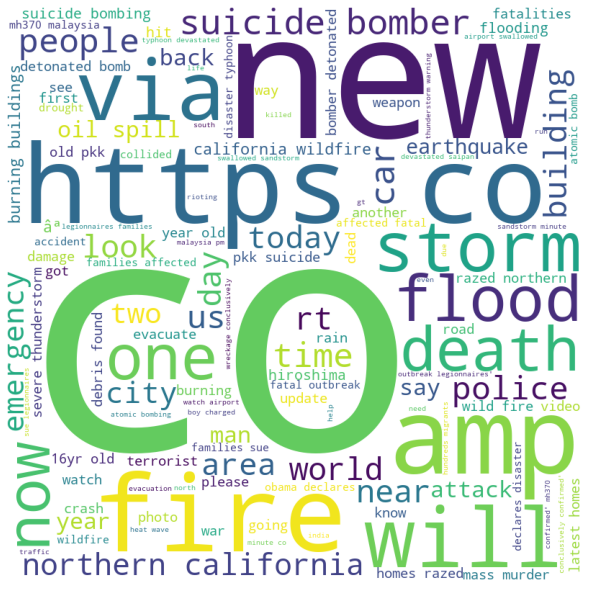

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  

all_words=[]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in pos.text: 
  
    # split tweet into words 
    tokens = val.split() 
    #print(tokens)
    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    all_words.extend(tokens)
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

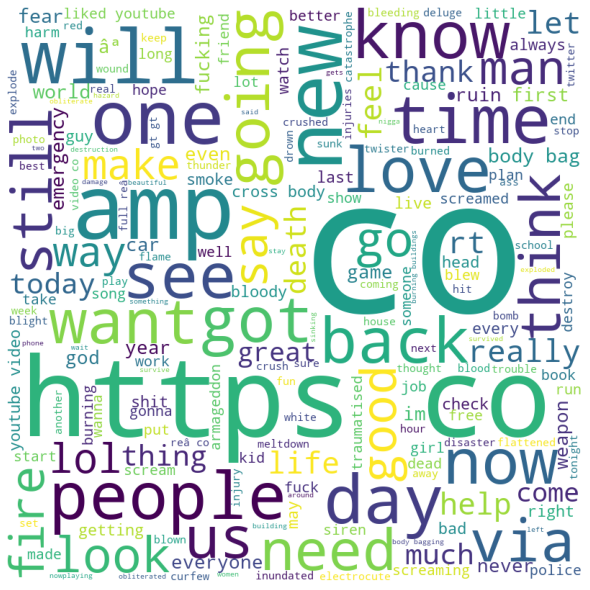

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  

all_words=[]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in neg.text: 
  
    # split tweet into words 
    tokens = val.split() 
    #print(tokens)
    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    all_words.extend(tokens)
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Word Cloud de Keywords simples

In [0]:
SingleKeywords = train2_df['keyword'].str.split('%20', expand=True)


In [0]:
# Defino funcion para colorear palabras de wordcloud con un semaforo : Verde (1/3 < mean target), Amarillo (1/3 < mean target < 2/3), Rojo (2/3 < mean target)
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    if dictionary[word] >= (2/3):
      return "rgb(255,0,0)"
    elif dictionary[word] >= (1/3):
      return "rgb(255,255,0)"
    return "rgb(0,255,0)"
  return my_tf_color_func_inner

In [0]:
from matplotlib import cm

#wordcloud.generate_from_frequencies({'hola': 10, 'pepe': 5})
d = {}
for index, row in keywordMeanTarget.iterrows():
    d[index] = row[0]#int(100 * row[0])

wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(d))#colormap=cm.inferno)
wordcloud.generate_from_frequencies(d)

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: ignored

#####Word Cloud de Keywords "simples" y Keywords "completos"


Word Cloud de Keywords simples


In [0]:
SingleKeywords = train2_df['keyword'].str.split('%20', expand=True)

In [0]:
# Defino funcion para colorear palabras de wordcloud con un semaforo : Verde (1/3 < mean target), Amarillo (1/3 < mean target < 2/3), Rojo (2/3 < mean target)
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    if dictionary[word] >= (2/3):
      return "rgb(255,0,0)"
    elif dictionary[word] >= (1/3):
      return "rgb(255,255,0)"
    return "rgb(0,255,0)"
  return my_tf_color_func_inner

In [0]:
from matplotlib import cm

#wordcloud.generate_from_frequencies({'hola': 10, 'pepe': 5})
d = {}
for index, row in keywordMeanTarget.iterrows():
    d[index] = row[0]#int(100 * row[0])

wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(d))#colormap=cm.inferno)
wordcloud.generate_from_frequencies(d)

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: ignored

In [0]:
SingleKeywords = df['keyword'].str.split('%20', expand=True)
SingleKeywords['target_kw0'] = df['target']
SingleKeywords['target_kw1'] = df['target']
SingleKeywords['target_kw2'] = df['target']
SKW_stats = pd.DataFrame([])
SKW_stats['SingleKeword'] = SingleKeywords[[0, 1, 2]].values.flatten()
SKW_stats['target'] = SingleKeywords[['target_kw0', 'target_kw1', 'target_kw2']].values.flatten()
SKW_stats.dropna(inplace=True)
SKW_stats = SKW_stats.groupby(['SingleKeword']).agg(['mean', 'count']).sort_values(by=('target', 'mean'), ascending=True)
SKW_stats

In [0]:
fig, ax1 = plt.subplots(figsize=(12, 30), dpi=100)

color = 'tab:red'
ax1.set_ylabel('keyword')
ax1.set_xlabel('Mean target', color=color)
ax1.barh(SKW_stats.index, width=SKW_stats[('target', 'mean')], height=0.8, color=color, alpha=0.7, label='Mean Target')

ax2 = ax1.twiny()  
color = 'tab:blue'
ax2.set_xlabel('Count', color=color)  
ax2.barh(SKW_stats.index, width=SKW_stats[('target', 'count')], height=0.8, color=color, alpha=0.5, label='Count')

ax1.margins(0, 0)
ax2.margins(0, 0)

import matplotlib.patches as mpatches
meanTarget_patch = mpatches.Patch(color='tab:red', label='Mean Target')
count_patch = mpatches.Patch(color='tab:blue', label='Count')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98), handles=[meanTarget_patch, count_patch]) 

ax2.spines["bottom"].set_position(("axes", -0.015))
ax1.spines["top"].set_position(("axes", 1.015))
ax2.spines["bottom"].set_visible(True)
ax1.spines["top"].set_visible(True)
plt.title('Distribución de Desastres por Keyword SIMPLE', color=(0.05,0.05,0.05), pad=25, fontsize=18)
fig.tight_layout()
ax1.tick_params(axis='y', labelcolor= (0.05, 0.05, 0.05), labelsize=8)
ax1.tick_params(axis='x', labelcolor='tab:red', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax2.tick_params(axis='x', labelcolor='tab:blue', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax1.xaxis.set_label_coords(1.07, 1.023)
ax2.xaxis.set_label_coords(1.07, 1.003)
plt.show()

In [0]:
# Defino funcion para colorear palabras de wordcloud con un semaforo : Verde (1/3 < mean target), Amarillo (1/3 < mean target < 2/3), Rojo (2/3 < mean target)
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    if dictionary[word] >= (2/3):
      return "rgb(255,0,0)"
    elif dictionary[word] >= (1/3):
      return "rgb(255,255,0)"
    return "rgb(0,255,0)"
  return my_tf_color_func_inner

In [0]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(SKW_stats[('target', 'mean')]))
wordcloud.generate_from_frequencies(SKW_stats[('target', 'mean')])

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de Keywords SIMPLES segun media de observaciones positivas (target mean)', color=(0.05,0.05,0.05), pad=10, fontsize=18)

red_patch = mpatches.Patch(color='red', label='(2/3) < Target Mean')
yellow_patch = mpatches.Patch(color='yellow', label='(1/3) < Target Mean < (2/3)')
green_patch = mpatches.Patch(color='green', label='Target Mean < (1/3)')
plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.98), handles=[red_patch, yellow_patch, green_patch]) 
plt.show()

In [0]:
KW_stats = df[['keyword', 'target']]
KW_stats.set_index('keyword')
KW_stats.dropna(inplace=True)
KW_stats = KW_stats.groupby(['keyword']).agg(['mean', 'count']).sort_values(by=('target', 'mean'), ascending=True)
KW_stats

In [0]:
fig, ax1 = plt.subplots(figsize=(12, 30), dpi=100)

color = 'tab:red'
ax1.set_ylabel('keyword')
ax1.set_xlabel('Mean target', color=color)
ax1.barh(KW_stats.index, width=KW_stats[('target', 'mean')], height=0.8, color=color, alpha=0.7, label='Mean Target')

ax2 = ax1.twiny()  
color = 'tab:blue'
ax2.set_xlabel('Count', color=color)  
ax2.barh(KW_stats.index, width=KW_stats[('target', 'count')], height=0.8, color=color, alpha=0.5, label='Count')

ax1.margins(0, 0)
ax2.margins(0, 0)

import matplotlib.patches as mpatches
meanTarget_patch = mpatches.Patch(color='tab:red', label='Mean Target')
count_patch = mpatches.Patch(color='tab:blue', label='Count')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98), handles=[meanTarget_patch, count_patch]) 

ax2.spines["bottom"].set_position(("axes", -0.015))
ax1.spines["top"].set_position(("axes", 1.015))
ax2.spines["bottom"].set_visible(True)
ax1.spines["top"].set_visible(True)
plt.title('Distribución de Desastres por Keyword', color=(0.05,0.05,0.05), pad=25, fontsize=18)
fig.tight_layout()
ax1.tick_params(axis='y', labelcolor= (0.05, 0.05, 0.05), labelsize=8)
ax1.tick_params(axis='x', labelcolor='tab:red', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax2.tick_params(axis='x', labelcolor='tab:blue', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax1.xaxis.set_label_coords(1.07, 1.023)
ax2.xaxis.set_label_coords(1.07, 1.003)
plt.show()

In [0]:
wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(KW_stats[('target', 'mean')]))
wordcloud.generate_from_frequencies(KW_stats[('target', 'mean')])

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de Keywords segun media de observaciones positivas (target mean)', color=(0.05,0.05,0.05), pad=10, fontsize=18)

red_patch = mpatches.Patch(color='red', label='(2/3) < Target Mean')
yellow_patch = mpatches.Patch(color='yellow', label='(1/3) < Target Mean < (2/3)')
green_patch = mpatches.Patch(color='green', label='Target Mean < (1/3)')
plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.98), handles=[red_patch, yellow_patch, green_patch]) 
plt.show()

##### Metas

Puede ser que los desaster tweets (target = 1) esten escritos de manera mas "formal" o completa que los no disaster (target = 0). Analisamos las siguientes caracteristicas:



In [0]:
#punctuation_count number of punctuations in text - NO


*  word_count numero de palabras en text
*  unique_word_count numero unico de palabras en text
*  stop_word_count numero de stop words (conjunciones, conectores, etc) en text
*  url_count numero de urls en text
*  mean_word_length promedio de caracteres en palabras
*  char_count numero de caracteres en text
*  hashtag_count numero de hashtags (#) en text
*  mention_count numero de arrobas (@) en text

In [0]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

NameError: ignored

In [0]:
# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))



In [0]:
# hashtag_count
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [0]:
#no la hice
# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models...

In [0]:
#'punctuation_count'
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [0]:
# Se puede observar que a pesar de haber tweets más largos en caso de desaastre, el promedio de palabras parece conservarse.
# Es probable que sea "gritando" via texto.


In [0]:
# se observa una longitud mayor en los tweets asociados a un desastre


##### Violin chart ?

sobre disaster non disaster and longitud del texto en caracteres.